In [3]:
import operator
import numpy as np
import torch
import torch.nn.functional as F

from torch.nn import Module, Conv1d, Linear
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, TensorDataset

from functools import reduce, partial
from matplotlib import pyplot as plt

from lafomo.datasets import ToyTimeSeries, ToySpatialTranscriptomics

(84050, 4)
(1681, 4)
torch.Size([45, 41, 41, 1]) hi
torch.Size([45, 41, 41, 3]) torch.Size([5, 41, 41, 3])
torch.float32 torch.float32


/Users/jacob/miniconda3/envs/wishart/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


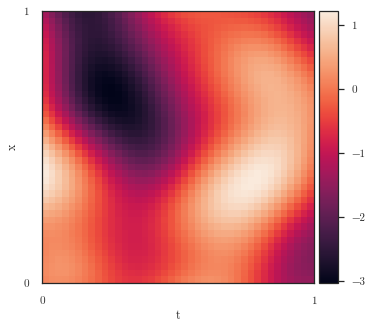

In [66]:
from lafomo.utilities.torch import get_image
from lafomo.plot import Plotter, plot_spatiotemporal_data

dataset = ToySpatialTranscriptomics('../../data', one_fixed_sample=False)

i = 49
orig_data = dataset.orig_data[1681*(i):1681*(i+1)]
print(orig_data.shape)
images = [get_image(orig_data, i) for i in range(2, 4)]
tx = dataset.data[0][0]
num_t = tx[0, :].unique().shape[0]
num_x = tx[1, :].unique().shape[0]

ts = tx[0, :].unique().sort()[0].numpy()
xs = tx[1, :].unique().sort()[0].numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]

plot_spatiotemporal_data(
    [torch.tensor(orig_data[:, 2]).view(num_t, num_x).t()],
    extent, nrows=1, ncols=1
)

ntrain = 45
ntest = 5
block_dim = 2
batch_size = 45
learning_rate = 0.001

epochs = 500
step_size = 100
gamma = 0.5

modes = 12
width = 32
s = 41

tx, _ = dataset.data[0]
grid = tx.t()
grid = torch.tensor(grid.reshape(1,s,s,2), dtype=torch.float)

data = torch.tensor(dataset.orig_data.reshape(len(dataset), s, s, 4), dtype=torch.float)
y_train = data[:ntrain, ..., 2:3]
x_train = data[:ntrain, ..., 3]
y_test = data[ntrain:, ..., 2:3]
x_test = data[ntrain:, ..., 3]

x_train = torch.cat([x_train.reshape(ntrain,s,s,1), grid.repeat(ntrain,1,1,1)], dim=3)
x_test = torch.cat([x_test.reshape(ntest,s,s,1), grid.repeat(ntest,1,1,1)], dim=3)
print(x_train.shape, x_test.shape)
print(x_train.dtype, x_test.dtype)
train_loader = DataLoader(torch.utils.data.TensorDataset(x_train, y_train),
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(torch.utils.data.TensorDataset(x_test, y_test),
                          batch_size=ntest, shuffle=False)

In [20]:
num_outputs = 10
basal_rate = 0.1 + 0.3 * torch.rand(torch.Size([num_outputs, 1]), dtype=torch.float32)
sensitivity = 2 + 5 * torch.rand(torch.Size([num_outputs, 1]), dtype=torch.float32)
decay_rate = 0.2 + 2 * torch.rand(torch.Size([num_outputs, 1]), dtype=torch.float32)


In [3]:
ntrain = 15
ntest = 5
learning_rate = 1e-3
batch_size = ntrain

datasets = list()
for i in range(ntrain + ntest):
    dataset = ToyTimeSeries(num_outputs, 1, 10, params=[basal_rate, sensitivity, decay_rate], plot=False)
    datasets.append(dataset)

In [24]:
x_train = torch.cat([dataset.m_observed for dataset in datasets[:ntrain]]).permute(0, 2, 1)
x_test = torch.cat([dataset.m_observed for dataset in datasets[ntrain:]]).permute(0, 2, 1)
T_in = 11
grid = datasets[0].t_observed.reshape(1, -1, 1).repeat(ntrain, 1, 1) # (1, 32, 32, 40, 1)
grid_test = datasets[0].t_observed.reshape(1, -1, 1).repeat(ntest, 1, 1) # (1, 32, 32, 40, 1)

x_train = torch.cat([grid, x_train], dim=-1)
x_test = torch.cat([grid_test, x_test], dim=-1)
y_train = torch.cat([dataset.f_observed for dataset in datasets[:ntrain]]).permute(0, 2, 1)
y_test = torch.cat([dataset.f_observed for dataset in datasets[ntrain:]]).permute(0, 2, 1)
print('y', y_train.shape)
print('x', x_train.shape)

train_loader = DataLoader(torch.utils.data.TensorDataset(x_train, y_train),
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(torch.utils.data.TensorDataset(x_test, y_test),
                          batch_size=ntest, shuffle=True)


y torch.Size([15, 11, 1])
x torch.Size([15, 11, 11])


In [73]:
from lafomo.nn import SpectralConv1d, LpLoss
from torch.nn import Conv2d


from lafomo.nn import SimpleBlock1d


In [74]:
width = 20
modes = 4
model = OperatorModel(block_dim, modes, width)
print(model.count_params())

55777


In [75]:
gamma = 0.5
step_size = 100
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
myloss = LpLoss(size_average=False)

In [108]:
epochs = 50

for ep in range(epochs):
    model.train()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        # x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)

        mse = F.mse_loss(out, y, reduction='mean')
        # mse.backward()
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # use the l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    test_mse = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            # x, y = x.cuda(), y.cuda()

            out = model(x)
            test_mse += F.mse_loss(out, y, reduction='mean')
            test_l2 += myloss(
                out.view(test_loader.batch_size, -1), y.view(test_loader.batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    test_mse /= ntest

    print(f'Epoch {ep}/{epochs}: MSE (train/test): {train_mse:.03f} {test_mse:.03f} L2 (train/test): {train_l2:.03f}, {test_l2:.03f}')

Epoch 0/50: MSE (train/test): 0.346 0.086 L2 (train/test): 0.611, 0.629
Epoch 1/50: MSE (train/test): 0.345 0.088 L2 (train/test): 0.610, 0.635
Epoch 2/50: MSE (train/test): 0.343 0.087 L2 (train/test): 0.608, 0.633
Epoch 3/50: MSE (train/test): 0.341 0.086 L2 (train/test): 0.607, 0.631
Epoch 4/50: MSE (train/test): 0.340 0.088 L2 (train/test): 0.605, 0.636
Epoch 5/50: MSE (train/test): 0.338 0.086 L2 (train/test): 0.604, 0.629
Epoch 6/50: MSE (train/test): 0.337 0.087 L2 (train/test): 0.603, 0.635
Epoch 7/50: MSE (train/test): 0.335 0.085 L2 (train/test): 0.601, 0.629
Epoch 8/50: MSE (train/test): 0.334 0.086 L2 (train/test): 0.599, 0.632
Epoch 9/50: MSE (train/test): 0.332 0.086 L2 (train/test): 0.598, 0.631
Epoch 10/50: MSE (train/test): 0.330 0.085 L2 (train/test): 0.597, 0.629
Epoch 11/50: MSE (train/test): 0.329 0.086 L2 (train/test): 0.595, 0.633
Epoch 12/50: MSE (train/test): 0.327 0.085 L2 (train/test): 0.594, 0.628
Epoch 13/50: MSE (train/test): 0.326 0.087 L2 (train/test): 0

torch.Size([5, 41, 41, 3]) torch.Size([5, 41, 41, 1])
torch.Size([5, 41, 41, 1])
torch.Size([5, 41, 41, 3])


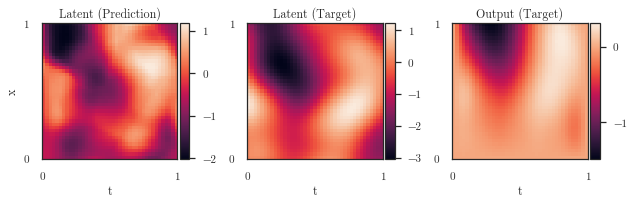

In [109]:
x, y = next(iter(test_loader))
print(x.shape, y.shape)
out = model(x)
print(out.shape)

if block_dim == 1:
    fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
    for i in range(1, 5):
        axes[0].plot(x[0, :, i])#.shape, y.shape)
    axes[1].plot(y[0, :, 0])
    axes[1].plot(out[0, :, 0].detach())
else:
    #axes[0].imshow(x[0, ..., 0])
    print(x.shape)
    plot_spatiotemporal_data(
        [
            out[0, ..., 0].detach().view(num_t, num_x).t(),
            y[0, ..., 0].view(num_t, num_x).t(),
            x[0, ..., 0].view(num_t, num_x).t()
        ],
        extent, nrows=1, ncols=3,
        titles=['Latent (Prediction)', 'Latent (Target)', 'Output (Target)']
    )

In [ ]:
dataset = ToySpatialTranscriptomics('../../data', one_fixed_sample=False)

In [310]:
# torch.save(model, 'model/ns_fourier_burgers_8192')
pred = torch.zeros(y_train.shape)
index = 0
# test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        # x, y = x.cuda(), y.cuda()

        out = model(x)
        pred[index] = out

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        print(index, test_l2)
        index = index + 1

NameError: name 'test_loader' is not defined

/Users/jacob/miniconda3/envs/wishart/lib/python3.7/site-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


<HDF5 file "ns_V1e-3_N5000_T50.mat" (mode r+)>
<HDF5 dataset "u": shape (50, 64, 64, 5000), type "<f4">
10 0.0025 100 0.5
torch.Size([100, 32, 32, 40, 10])
torch.Size([1, 32, 32, 40, 1]) torch.Size([1, 32, 32, 40, 1])
torch.Size([100, 32, 32, 40, 1])
torch.Size([100, 32, 32, 40, 13])


In [ ]:
path = '../../data/ns_V1e-3_N5000_T50.mat'
from h5py import File

# u shape (50, 64, 64, 5000)
# a shape (64, 64, 5000)
# t shape (50, 1)

f = File(path)
print(f)
print(f['u'])

modes = 4
width = 20

batch_size = 10
batch_size2 = batch_size

epochs = 10
learning_rate = 0.0025
scheduler_step = 100
scheduler_gamma = 0.5

print(epochs, learning_rate, scheduler_step, scheduler_gamma)


runtime = np.zeros(2, )

ntrain = 100
sub = 1
S = 64 // sub
T_in = 10
T = 40
S = 32

# train_a = reader.read_field('u')[:ntrain,::sub,::sub,:T_in]
# train_u = reader.read_field('u')[:ntrain,::sub,::sub,T_in:T+T_in]
train_a = torch.rand((100, 32, 32, 50))[:, :, :, :T_in]
train_a = train_a.reshape(ntrain,S,S,1,T_in).repeat([1,1,1,T,1])
print(train_a.shape)
# pad locations (x,y,t)
gridx = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
# 32
gridx = gridx.reshape(1, S, 1, 1, 1).repeat([1, 1, S, T, 1])
# 1, 32, 32, 40, 1 (1, S, S, T, 1)
gridy = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridy = gridy.reshape(1, 1, S, 1, 1).repeat([1, S, 1, T, 1])
gridt = torch.tensor(np.linspace(0, 1, T+1)[1:], dtype=torch.float)
gridt = gridt.reshape(1, 1, 1, T, 1).repeat([1, S, S, 1, 1])
# (1, S, S, T, 1)
print(gridt.shape, gridx.shape)
# for t in range(10):
#     plt.figure()
#     plt.imshow(gridy.squeeze()[:, :, t])
print(gridx.repeat([ntrain,1,1,1,1]).shape)
train_a = torch.cat((gridx.repeat([ntrain,1,1,1,1]), gridy.repeat([ntrain,1,1,1,1]),
                       gridt.repeat([ntrain,1,1,1,1]), train_a), dim=-1)
print(train_a.shape)

torch.Size([100, 32, 32, 40, 13])


In [ ]:
# This part checks our complex multiplication code:
def compl_mul1d(a, b):
    # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
    op = partial(torch.einsum, "bix,iox->box")
    return torch.stack([
        op(a[..., 0], b[..., 0]) - op(a[..., 1], b[..., 1]),
        op(a[..., 1], b[..., 0]) + op(a[..., 0], b[..., 1])
    ], dim=-1)

weights1_sep = torch.rand(20, 20, 4, 2)
weights1_sep = torch.rand(64, 64, 4, 2)
weights1 = weights1_sep[:, :, :, 0] + weights1_sep[:, :, :, 1] * 1j
x = torch.randn((15, 20, 11))
x = torch.randn((100, 64, 1024))
print(x.shape)

In [ ]:
x_ft = torch.fft.rfft(x)
x_ft_sep = torch.stack([
    torch.real(x_ft),
    torch.imag(x_ft)
    ], dim=-1)
print(x_ft_sep.shape)

In [ ]:
mul2 = compl_mul1d(x_ft_sep[:, :, :4], weights1_sep)
print(mul2)

In [ ]:
op = partial(torch.einsum, "bix,iox->box")
    # return torch.stack([
    #     op(a[..., 0], b[..., 0]) - op(a[..., 1], b[..., 1]),
    #     op(a[..., 1], b[..., 0]) + op(a[..., 0], b[..., 1])
    # ], dim=-1)

A = x_ft[:, :, :4]#.unsqueeze(1)
B = weights1#.unsqueeze(0)
print(A.shape, B.shape)
print(A.type())
# print(B.type(torch.complex64))
mul = op(A, B.type(torch.complex64))
# mul = torch.matmul(A, B)
print(mul.shape, mul2.shape)

print(mul2[where])



In [ ]:
ntrain = 1000
ntest = 100

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h

batch_size = 20
learning_rate = 0.001

grid = np.linspace(0, 2*np.pi, s).reshape(1, s, 1)
grid = torch.tensor(grid, dtype=torch.float)
x_train = torch.randn(ntrain, s, 1)
x_train = torch.cat([x_train.reshape(ntrain,s,1), grid.repeat(ntrain,1,1)], dim=2)

modes = 16
width = 64
print(x_train.shape)
x = Linear(2, width)(x_train).permute(0, 2, 1)
print(x.shape)